# Shallow Focus 

pretrained deeplab model을 사용하면, 이미지를 21개 (20 클래스 + 배경)으로 segmentation 할 수 있습니다.
cv2를 함께 사용하여 원하는 부분을 제외하고 blur 시키는 Soft Focus를 구현해 봅니다

## load model

import libraries & load image

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/HJM.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(420, 600, 3)


In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

DeepLabModel 객체를 생성하고, 훈련이 완료된 모델을 다운로드하여 불러옵니다

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(420, 600, 3) (359, 513, 3) 15


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

Deeplab을 이용해 21개의 label로 image segmentation을 실행합니다.

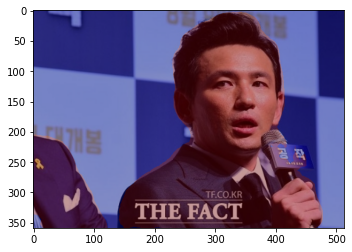

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

resize mask

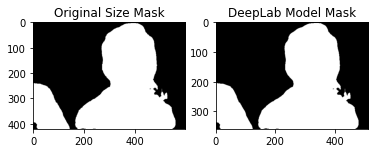

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

blur

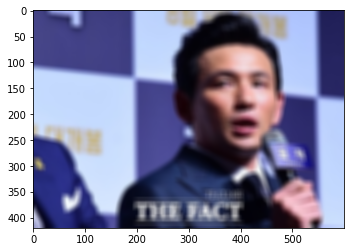

In [9]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

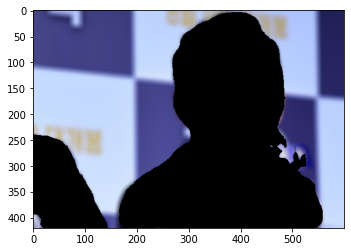

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

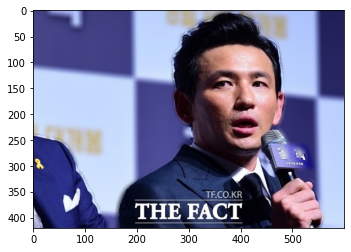

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
import os
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/MJ.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path2) 
print (img_orig.shape)

(961, 961, 3)


In [13]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(961, 961, 3) (513, 513, 3) 15


In [14]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

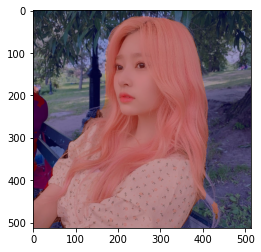

In [15]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

resize mask

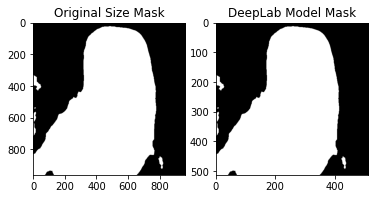

In [16]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

blur

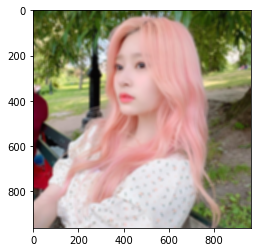

In [17]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

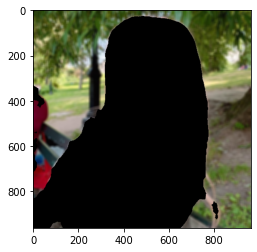

In [18]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

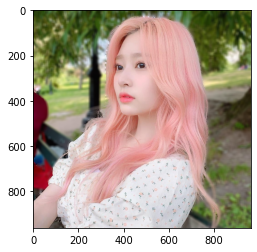

In [19]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
import os
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/NBR.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path3) 
print (img_orig.shape)

(404, 540, 3)


In [21]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(404, 540, 3) (383, 513, 3) 15


In [22]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

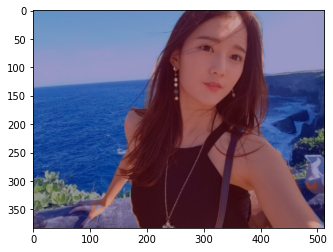

In [23]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

resize mask

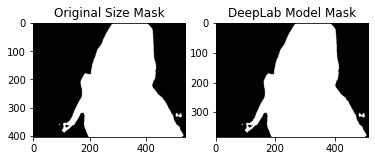

In [24]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

blur

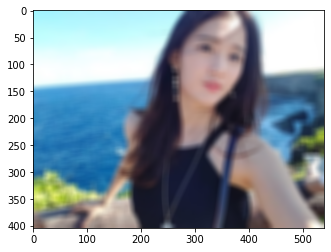

In [25]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

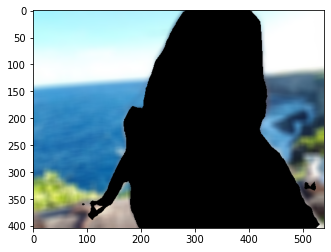

In [26]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

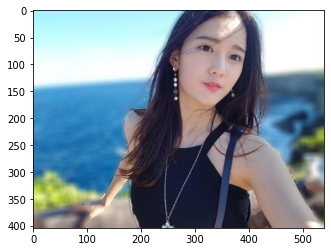

In [27]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# Project

필요한 절차만 모아 함수로 만들면 다음과 같습니다.

In [28]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

LABEL_ENCODING = {label: idx for idx, label in enumerate(LABEL_NAMES)}

In [29]:
def basic_shallow_focus(img_path, label_str, blur_level=13):
    label = LABEL_ENCODING[label_str]
    
    img_orig = cv2.imread(img_path)
    img_resized, seg_map = MODEL.run(img_orig)
    
    seg_map = np.where(seg_map == label, label, 0) # 예측 중 label만 추출
    img_mask = seg_map * (255/(seg_map.max() + 1e-10)) # 255 normalization, divisionerror 방지
    img_mask = img_mask.astype(np.uint8)
    
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)    
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    
    img_orig_blur = cv2.blur(img_orig, (blur_level,blur_level)) # blurring  kernel size를 뜻합니다. 

    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

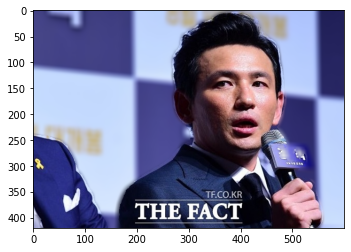

In [30]:
basic_shallow_focus(img_path, 'person')

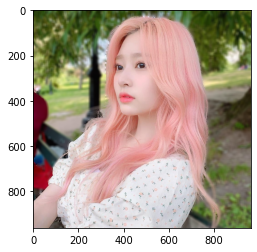

In [31]:
basic_shallow_focus(img_path2, 'person')

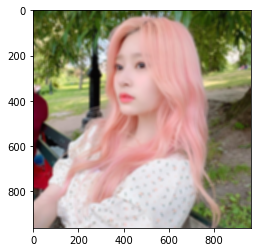

In [32]:
basic_shallow_focus(img_path2, 'cat')

변환이 잘 된 것을 확인했습니다. 사진에 예측되지 않은 label 기준으로 shallow focus를 진행하면, 모두 blur처리 된 것을 볼 수 있습니다

### 고양이 사진 shallow focus

이제 고양이 사진에 대해서 시도해 보겠습니다

In [33]:
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat1.jpg' 
cat_img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.jpg'
people_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/people.jpg'

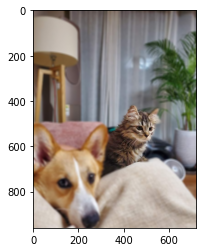

In [34]:
basic_shallow_focus(cat_img_path2, 'cat', 10)

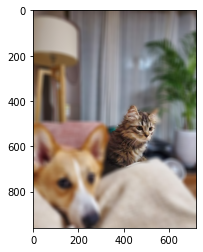

In [35]:
basic_shallow_focus(cat_img_path2, 'cat', 20)

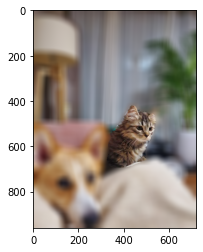

In [36]:
basic_shallow_focus(cat_img_path2, 'cat', 35)

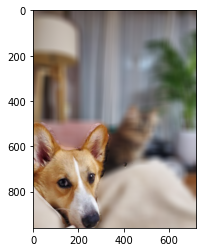

In [37]:
basic_shallow_focus(cat_img_path2, 'dog', 35)

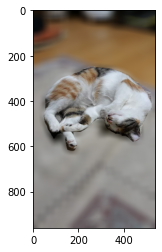

In [38]:
basic_shallow_focus(cat_img_path, 'cat', 40)

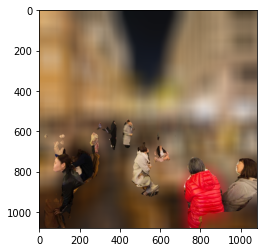

In [39]:
basic_shallow_focus(people_img_path, 'person', 100)

### 배경 크로마키

지금까지의 테크닉을 응용한다면 원하는 배경에 잘라낸 이미지를 합성하는 크로마키 처리도 가능할 것입니다. 함수를 수정합니다.
이 때, 원래의 이미지와 배경 이미지의 크기가 다르다면, 디폴트로는 배경 이미지의 중앙에 원본 이미지를 얹도록 하고, 얹을 위치 역시 비율을 인자로 받아 얹도록 합니다.

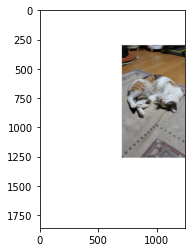

In [40]:
# 사진에 배경을 입히는 copyMakeBorder를 사용해 봅니다. 


img = cv2.imread(cat_img_path)
borderType = cv2.BORDER_CONSTANT
image = cv2.copyMakeBorder(img, 300, 600, 700, 0, borderType, value=(255,255,255))  # top, bottom, left, right
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

배경으로 사용할 이미지의 경로를 지정합니다. 만약 배경 이미지 경로가 지정되지 않으면 basic_shallow_focus()를 실행하고 0을 반환합니다.

배경이 주어진 경우, 원본 이미지의 비율을 유지한 채로, 배경/원본이 작은 쪽으로 resize 후, 패딩을 추가합니다. 

ratio(0~1)를 인자로 주어 위치를 설정합니다 

In [41]:
def shallow_focus_chromakey(img_path, label_str, *, blur_level, bg_img_path=None, ratio=0.5):
    if bg_img_path is None:  # 배경 이미지  경로가 주어지지 않으면 원본 이미지 사용
        basic_shallow_focus(img_path, label_str, blur_level)
        print("shallow focus done on original image")
        return 0 # 원본 이미지에 blur 처리를 했으면 0을 반환합니다
    label = LABEL_ENCODING[label_str]
    
    img_orig = cv2.imread(img_path)
    bg_img_orig = cv2.imread(bg_img_path)  # 배경 이미지를 읽어옵니다
    img_resized, seg_map = MODEL.run(img_orig)
    
    seg_map = np.where(seg_map == label, label, 0) # 예측 중 label만 추출
    img_mask = seg_map * (255/(seg_map.max() + 1e-10)) # 255 normalization, divisionerror 방지
    img_mask = img_mask.astype(np.uint8)
    
    #### 
    original_h, original_w = img_orig.shape[:2][::-1]  # cv2.imread()로 읽은 이미지의 shape는 width, height 순서이므로 h, w 순서로 만들어줍니다
    bg_h, bg_w = bg_img_orig.shape[:2][::-1]
    
    if (bg_h/original_h) >= (bg_w/original_w):  # 원본 이미지를 배경 이미지의 height와 width 중 배경/원본이 작은 쪽으로 맞춥니다. 
                # 원본 이미지: (960, 540), 배경 이미지: (1260, 1080)  ->  세로 비: 1260 / 960 = 1.3125, 가로 비: 1080 / 540 = 2 -> 세로 쪽에 맞춥니다.
                # 변환 후 이미지 : (1260, 709)
        resize_shape = (int(original_h * bg_w / original_w), bg_w)
    else:
        resize_shape = (bg_h, int(original_w * bg_h / original_h))
    ####
    
    
    img_mask_up = cv2.resize(img_mask, resize_shape, interpolation=cv2.INTER_LINEAR)  # mask와 원본 이미지를 모두 배경에 맞춰 resize합니다
    img_orig_up = cv2.resize(img_orig, resize_shape, interpolation=cv2.INTER_LINEAR)
    
    resized_w, resized_h = resize_shape  # 가로, 세로 중 한 쪽은 배경 이미지와 동일합니다
    width_diff = bg_w - resized_w  # 배경 이미지와 변환 후 이미지의 가로 차이입니다
    height_diff = bg_h - resized_h  # 배경 이미지와 변환 후 이미지의 세로 차이입니다
    
    top_padding = int(height_diff * ratio)  # 원본 이미지에서 잘라낸 부분을 정 중앙에 두기 위해 양쪽에 같은 패딩을 줍니다
    left_padding = int(width_diff * ratio)  # 원본 이미지에서 잘라낸 부분을 정 중앙에 두기 위해 양쪽에 같은 패딩을 줍니다
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    
    
    # top, bottom, left, right
    img_mask_up = cv2.copyMakeBorder(img_mask_up, top_padding, height_diff-top_padding, left_padding, width_diff-left_padding, borderType, value=0)
    img_orig_up = cv2.copyMakeBorder(img_orig_up, top_padding, height_diff-top_padding, left_padding, width_diff-left_padding, borderType, value=0)
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    
    plt.imshow(img_mask_color)
    plt.show()
    
    bg_img_orig_blur = cv2.blur(bg_img_orig, (blur_level,blur_level)) # blurring  kernel size를 뜻합니다. 

    img_bg_mask = cv2.bitwise_not(img_mask_color)
    bg_img_bg_blur = cv2.bitwise_and(bg_img_orig_blur, img_bg_mask)

    
    img_concat = np.where(img_mask_color==255, img_orig_up, bg_img_bg_blur)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    return 1

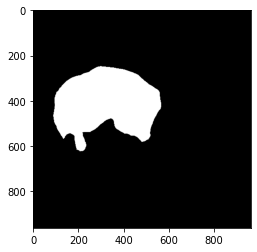

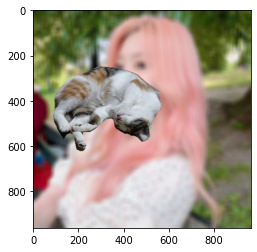

1

In [42]:
shallow_focus_chromakey(cat_img_path, 'cat', blur_level=25, bg_img_path=img_path2, ratio=0.1)

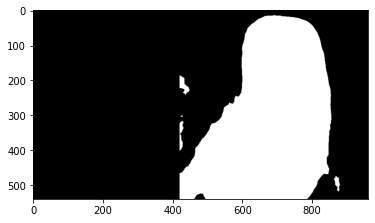

error: OpenCV(4.5.1) /tmp/pip-req-build-hj027r8z/opencv/modules/core/src/arithm.cpp:232: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'


In [43]:
shallow_focus_chromakey(img_path2, 'person', blur_level=25, bg_img_path=cat_img_path, ratio=1)

배경 이미지와 원본 이미지를 바꾸었더니, 에러가 발생했습니다. 이는 원본 이미지보다 배경 이미지가 더 작을 때 나타나는 현상으로, 추가적인 조건이 필요합니다. 

위처럼 생각했으나, 사실 imread()로 읽어온 이미지의 가로 세로 순서와, resize에 인자로 주는 shape의 가로 세로 순서를 반대로 생각해서 일어난 일이었습니다. 수정하면 다음과 같습니다

In [44]:
def shallow_focus_chromakey(img_path, label_str, *, blur_level, bg_img_path=None, ratio=0.5):
    if bg_img_path is None:  # 배경 이미지  경로가 주어지지 않으면 원본 이미지 사용
        basic_shallow_focus(img_path, label_str, blur_level)
        print("shallow focus done on original image")
        return 0 # 원본 이미지에 blur 처리를 했으면 0을 반환합니다
    label = LABEL_ENCODING[label_str]
    
    img_orig = cv2.imread(img_path)
    bg_img_orig = cv2.imread(bg_img_path)  # 배경 이미지를 읽어옵니다
    img_resized, seg_map = MODEL.run(img_orig)

    seg_map = np.where(seg_map == label, label, 0) # 예측 중 label만 추출
    img_mask = seg_map * (255/(seg_map.max() + 1e-10)) # 255 normalization, divisionerror 방지
    img_mask = img_mask.astype(np.uint8)
    
    #### 
    original_h, original_w = img_orig.shape[:2]  # cv2.imread()로 읽어와 height와 width를 저장합니다
    bg_h, bg_w = bg_img_orig.shape[:2]

    if (bg_h/original_h) >= (bg_w/original_w):  # 원본 이미지를 배경 이미지의 height와 width 중 배경/원본이 작은 쪽으로 맞춥니다. 
                # 원본 이미지: (960, 540), 배경 이미지: (1260, 1080)  ->  세로 비: 1260 / 960 = 1.3125, 가로 비: 1080 / 540 = 2 -> 세로 쪽에 맞춥니다.
                # 변환 후 이미지 : (1260, 709)
        resize_shape = (int(original_h * bg_w / original_w), bg_w)[::-1]  # cv2.resize에 인자로 넣을 것이므로
    else:
        resize_shape = (bg_h, int(original_w * bg_h / original_h))[::-1]  # 가로, 세로 순서로 넣어주어야 합니다
    ####
    
    
    img_mask_up = cv2.resize(img_mask, resize_shape, interpolation=cv2.INTER_LINEAR)  # mask와 원본 이미지를 모두 배경에 맞춰 resize합니다
    img_orig_up = cv2.resize(img_orig, resize_shape, interpolation=cv2.INTER_LINEAR)

    resized_w, resized_h = resize_shape  # 가로, 세로 중 한 쪽은 배경 이미지와 동일합니다
    width_diff = bg_w - resized_w  # 배경 이미지와 변환 후 이미지의 가로 차이입니다
    height_diff = bg_h - resized_h  # 배경 이미지와 변환 후 이미지의 세로 차이입니다

    top_padding = int(height_diff * ratio)  # 원본 이미지에서 잘라낸 부분을 정 중앙에 두기 위해 양쪽에 같은 패딩을 줍니다
    left_padding = int(width_diff * ratio)  # 원본 이미지에서 잘라낸 부분을 정 중앙에 두기 위해 양쪽에 같은 패딩을 줍니다
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
    
    
    # top, bottom, left, right
    img_mask_up = cv2.copyMakeBorder(img_mask_up, top_padding, height_diff-top_padding, left_padding, width_diff-left_padding, borderType, value=0)
    img_orig_up = cv2.copyMakeBorder(img_orig_up, top_padding, height_diff-top_padding, left_padding, width_diff-left_padding, borderType, value=0)
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)

    plt.imshow(img_mask_color)
    plt.show()

    bg_img_orig_blur = cv2.blur(bg_img_orig, (blur_level,blur_level)) # blurring  kernel size를 뜻합니다. 

    img_bg_mask = cv2.bitwise_not(img_mask_color)
    bg_img_bg_blur = cv2.bitwise_and(bg_img_orig_blur, img_bg_mask)


    img_concat = np.where(img_mask_color==255, img_orig_up, bg_img_bg_blur)

    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    return 1

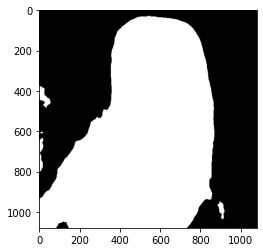

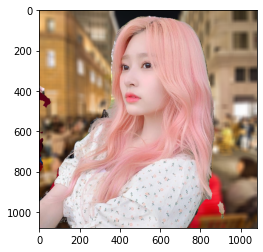

1

In [45]:
shallow_focus_chromakey(img_path2, 'person', blur_level=25, bg_img_path=people_img_path)

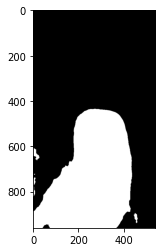

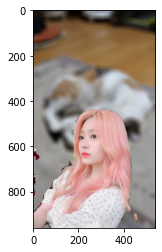

1

In [46]:
shallow_focus_chromakey(img_path2, 'person', blur_level=25, bg_img_path=cat_img_path, ratio=1)

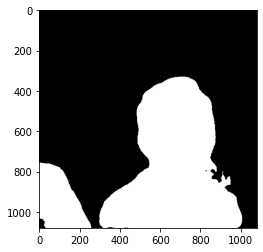

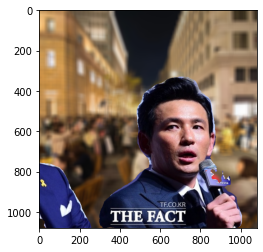

1

In [51]:
shallow_focus_chromakey(img_path, 'person', blur_level=25, bg_img_path=people_img_path, ratio=1)

# 문제점 분석

3장의 이미지에 대해서 처리한 결과, 배경의 거리가 동일할수록 자연스럽다는 것이 보입니다. 황정민 사진의 경우, 배경이 단일한 평면이므로, 사람 셋 중 가장 자연스럽습니다. 그러나 마이크의 일부를 사람으로 인식하거나 하는 문제가 있습니다. 또한, 공중에 이미지가 뜬 것 처럼 보입니다. 그리고 경계면 역시 자연스럽지 못합니다. 단 하나의 연결된 덩어리만 인식하도록 바꾸면 좋을 것 같습니다

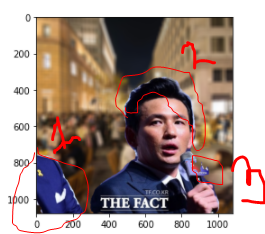

# 솔루션 제안

https://www.youtube.com/watch?v=QSVrKK_uHoU

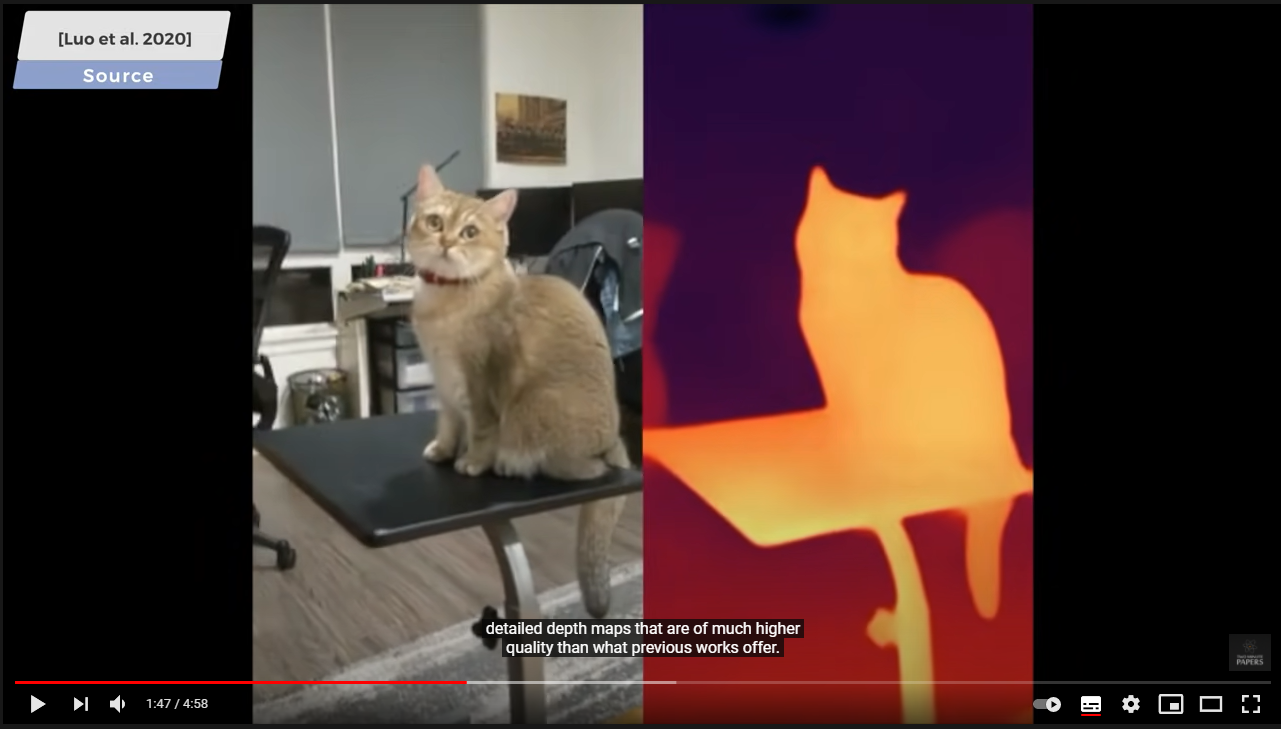

https://arxiv.org/pdf/2004.15021.pdf 를 보면, 위치 별로 depth map을 잘 그릴 수 있습니다.
segmentation된 부분의 depth 평균을 구하여 object_mean_depth로 저장합니다. depth가 3% 오차 범위 안에 들어오는 부분을 합집합으로 마스킹하고, 나머지 부분은 object_mean_depth와의 차이에 비례하여 blur_kernel의 사이즈를 키우면 될 것 같습니다.

# 회고

1️⃣ 잘한 점:

크로마키를 함수로 구현하여 결과를 내었다

2️⃣ 어려웠던 점:

솔루션을 만들어 보라는 점이 가장 어려웠다
depth map을 만들 수 있으면 segmentation의 정확도도 올라갈 텐데, 시간의 부족으로 링크한 논문을 자세히 읽어보지 못했다
비율이 다른 이미지와 배경을 사용할 때, 어떻게 합칠 것인지 아이디어를 생각하는 데 시간이 많이 들어가고, 에러도 많이 발생했다
    
3️⃣ 느낀 점:

segmentation을 잘 할 수 있으면 컴퓨터비전에서 많은 프로젝트를 효율적으로 사용할 수 있을 것 같다